# Stochastic simulation of genetic circuits

So this is based on a similar (read <a href="http://be150.caltech.edu/2016/handouts/gillespie_simulation.html" target="_blank">near identical script</a>)  
I have adapted it to run with 2 more populations, this is where it is fucking up  
I think there is an issue in the pop_  

In [1]:
import   multiprocessing

# NumPy and odeint, our workhorses http://be150.caltech.edu/2016/handouts/gillespie_simulation.html  
import   numpy   as   np
import   scipy.stats   as   st
import   numba

# Plotting modules  
import   matplotlib.pyplot   as   plt
import   seaborn   as   sns

# Line profiler
%load_ext line_profiler

# This is to enable inline displays for the purposes of the tutorial  
%matplotlib inline
%config InlineBackend.figure_formats = {  'png'  ,   'retina'  }

# JB's favorite Seaborn settings for notebooks  
rc = {  'lines.linewidth'  :   2  , 
    'axes.labelsize'  :   18  , 
    'axes.titlesize'  :   18  , 
    'axes.facecolor'  :   'DFDFE5'  }
sns.set_context(  'notebook'  ,   rc  =rc)
sns.set_style(  'darkgrid'  ,   rc  =rc)

This is the array from the orginal script. As you can see my needs are a bit more complex than a 2 player system.   

In [2]:
# # Column 0 is change in m, column 1 is change in p
# simple_update = np.array([[ 1,  0],
#                           [-1,  0],
#                           [ 0,  1],
#                           [ 0, -1]], dtype=np.int)

My array  

In [3]:
simple_update = np.array([[  1  ,  0  ,  0  ,  0  ],
                          [ -1  ,  0  ,  0  ,  0  ],
                          [  0  ,  1  ,  0  ,  0  ],
                          [  0  , -1  ,  0  ,  0  ],
                          [  0  ,  0  ,  1  ,  0  ],
                          [  0  , -1  ,  0  ,  0  ],
                          [  0  ,  0  , -1  ,  0  ],
                          [  0  ,  0  ,  0  ,  1  ],
                          [  0  ,  0  ,  0  , -1  ],
                          [  0  ,  0  , -1  ,  1  ]],  dtype=np.int)

In [38]:
simple_update.shape

(10, 4)

Ori parameters for the model and population names.   
The array called here is checked against the binary array from the last step, so in the ori file  
The $\beta_{m}$ for population {m} would be positive so the dimensionless equations are


$$\begin{align}\frac{\mathrm{d}m}{\mathrm{d}t} &= \beta_m - m\end{align}$$

$$\begin{align}\frac{\mathrm{d}p}{\mathrm{d}t} &= \beta_p m - \gamma p\end{align}$$

with $\gamma = \gamma_p/\gamma_m$

In [4]:
# def simple_propensity(params, population):
#     """
#     Returns an array of propensities given a set of parameters
#     and an array of populations.
#     """
#     # Unpack parameters
#     beta_m, beta_p, gamma = params
    
#     # Unpack population
#     m, p = population
    
#     return np.array([beta_m, 
#                      m, 
#                      beta_p * m, 
#                      gamma * p])

my paras and pop   

In [5]:
def simple_propensity(params, population):
    # Unpack parameters  
    vs, vr, c, w, e, d, k, bu, mu , nu = params # `nu` is never used 

    # Unpack population  
    R,S,Nr,P = population

    return   np.array([w*(c-R), 
                 (vs*S+vr*Nr)*(R/(R+k))*e, 
                 vs*(R/(R+k))*S, 
                 d*S*P*(R/(R+k)),
                 d*S*P*bu*(R/(R+k)),
                 w*S,
                 w*P,
                 vr*(R/(R+k))*Nr,
                 w*Nr,
                 mu*S]) # I replace `m` with `mu` - I don't know if that's correct!

In [6]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [7]:
# # Make dummy probs
# probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15])

# # print('Result from scipy.stats:')
# # %timeit sample_discrete_scipy(probs)

# print('\nResult from hand-coded method:')
# %timeit sample_discrete(probs)


Result from hand-coded method:
1.98 µs ± 70.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


☝️ <i>Why does this sample method get called and timed like this? What's it's purpose?</i>

In [8]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

so this is the function I think is giving me the headache. I think the pop_out is not the right size but I'm not sure what the update.shape does nor have to convince it to be an array with 4 cols   

In [12]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

End of G's doc

In [37]:
n_classes = simple_update.shape[1]
# Specify parameters for calculation
params = np.array([10, 2, 2, 2, 1, 2, 1, 0.4, 0.4, 0.4]) # values for [vs, vr, c, w, e, d, k, bu, mu, nu]
if len(params)!=simple_update.shape[0]:
    print('Update matrix and params length don\'t match')

time_points = np.linspace(0, 50, 101)
population_0 = np.array([0]*n_classes) # To start you have 4 populations you want to initialize to 0
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), n_classes))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

/home/minnie/.pyenv/versions/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/minnie/.pyenv/versions/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


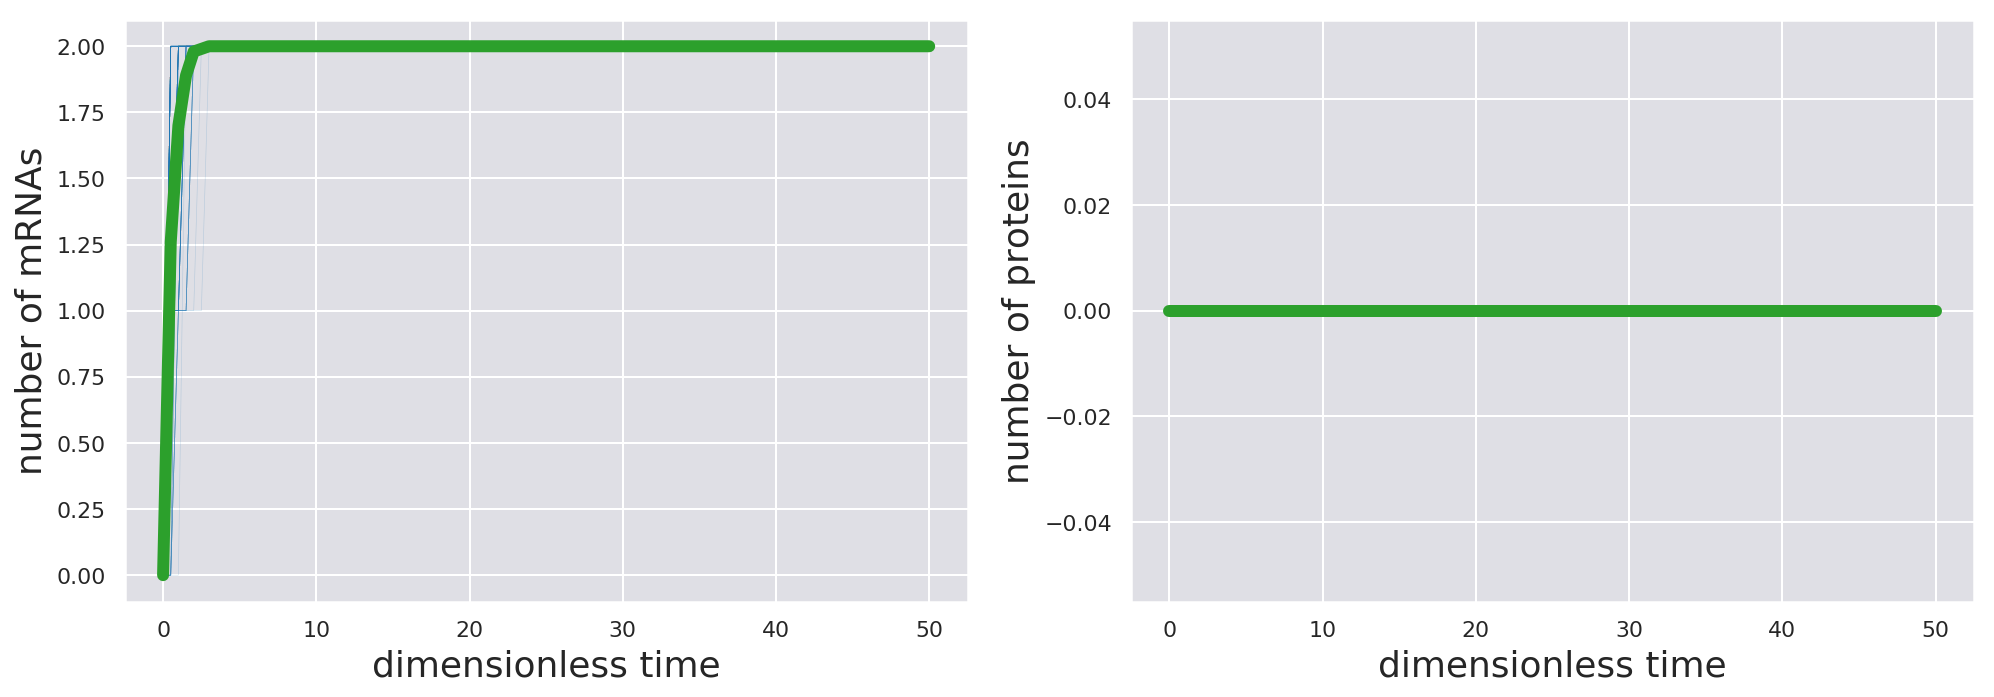

In [33]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()